In [106]:
# ------------------------ import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
from scipy.optimize import minimize
import seaborn as sns

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions


In [107]:
# ------------------------- import data
# importing dates and adjusted closing prices
ba = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\BA.csv", usecols = [0, 5])
intc = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\INTC.csv", usecols = [0, 5])
ko = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\KO.csv", usecols = [0, 5])
ms = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\MS.csv", usecols = [0, 5])
nflx = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\NFLX.csv", usecols = [0, 5])
nvda = pd.read_csv("C:\\Users\\Inno Mvula\\Desktop\\Kaggle files\\Projects - Time Series\\Portfolio Optimization\\NVDA.csv", usecols = [0, 5])

In [108]:
# --------------------------  rename adjusted closing pricing columns
tickers = ['BA', 'INTC', 'KO', 'MS', 'NFLX', 'NVDA']
dates = ['Date']
ticks = [ba, intc, ko, ms, nflx, nvda]
for i, j in zip(ticks, tickers):
    i.columns = ['Date', j] 


In [109]:
df = pd.concat(ticks, axis = 1)
dff = df.T.drop_duplicates().T

In [110]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1258 non-null   object
 1   BA      1258 non-null   object
 2   INTC    1258 non-null   object
 3   KO      1258 non-null   object
 4   MS      1258 non-null   object
 5   NFLX    1258 non-null   object
 6   NVDA    1258 non-null   object
dtypes: object(7)
memory usage: 68.9+ KB


In [111]:
# Our closing prices currently have object datatypes. This needs to be changed as we are dealing with numerical data.
ddata = pd.DataFrame(dff.iloc[:, 0], )
tdata = dff.iloc[:, 1:].astype('float64')

In [112]:
sdata = pd.concat([ddata, tdata], axis = 1).dropna().set_index('Date')

In [113]:
sdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 2016-07-22 to 2021-07-21
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BA      1258 non-null   float64
 1   INTC    1258 non-null   float64
 2   KO      1258 non-null   float64
 3   MS      1258 non-null   float64
 4   NFLX    1258 non-null   float64
 5   NVDA    1258 non-null   float64
dtypes: float64(6)
memory usage: 68.8+ KB


In [114]:
#plot percentage changes in the closing prices
pdata = (sdata/sdata.iloc[0])*100
pdata.head()

,BA,INTC,KO,MS,NFLX,NVDA
Date,,,,,,
2016-07-22,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2016-07-25,99.602912,100.086544,99.432690,100.726151,102.060781,101.847477
2016-07-26,101.033951,101.240648,97.927151,101.071932,106.426831,103.585160
2016-07-27,101.865600,100.490464,94.697798,101.037102,107.160324,102.542522
2016-07-28,99.655344,100.317360,95.243302,100.480033,106.706256,102.762044


<AxesSubplot:xlabel='Date'>

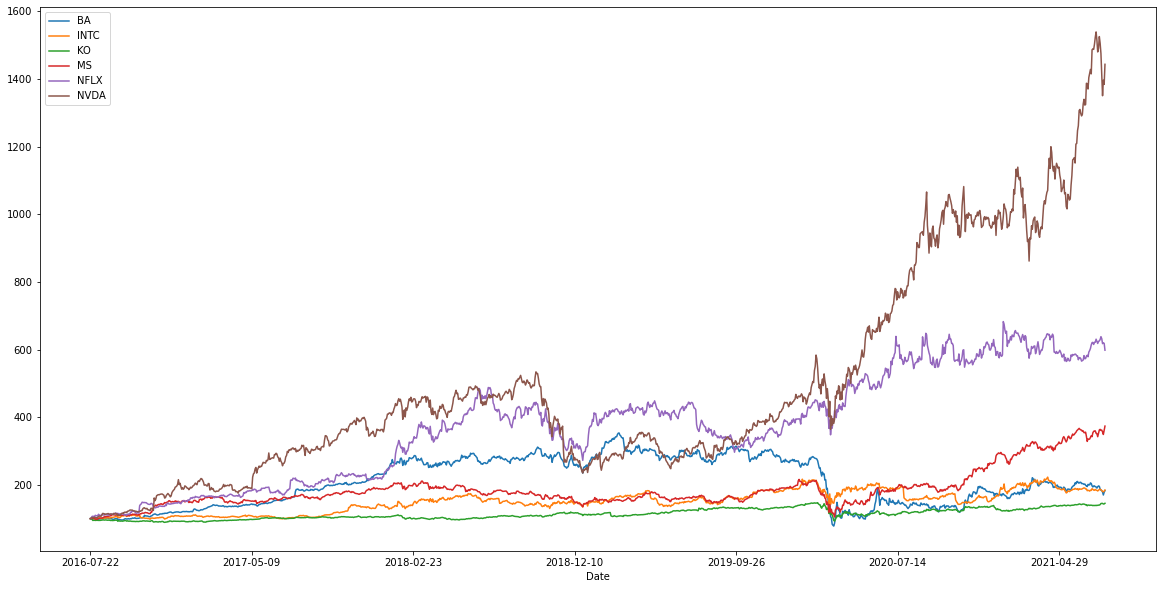

In [115]:
pdata.plot(figsize=(20, 10))

- We see that Nvidia has performed better than the other stocks. The growth rate of Nvidia stock price has picked up majorly after 2019. The stock with the lowest growth in stock prices is Coca Cola.

# 1.  Calculate returns and variances
- calculate returns
    - Compare log returns to simple returns
- calculate average daily returns and annualise
- calculate and annualise average daily variance

In [118]:
# 1. define a function that outputs annualised average daily returns of each individual asset
# use log returns
def log_returns(data):
    # first we compute the daily log returns of the assets
    log_returns = np.diff(np.log1p(data), axis = 0)
    return log_returns

def port_cov_matrix(data):
    cov_matrix = np.cov(log_returns(data).T)
    return cov_matrix

def annualised_asset_performance(data):
    # compute the average daily returns and then annualise
    log_mean_returns = np.mean(log_returns(data), axis = 0) * 252
    return log_mean_returns


# 2. define a function that outputs the annualised portfolio performance
def annualised_portfolio_performance(data, weights):
    returns = np.dot(weights, annualised_asset_performance(data))
    std = np.sqrt(np.dot(np.array(weights).T, np.dot(port_cov_matrix(data), weights) * 252))
    return returns, std

In [119]:
annualised_portfolio_performance(sdata, weights)

(0.24177749435555645, 0.25844069252560253)

# 2. Monte Carlo Simulation to find optimal portfolio
- This involves testing a variety of random weight allocations on our assets and seeing which one has the best Sharpe Ratio.
- We're going to randomly assign weights to each stock in our portfolio, and then calculate the mean daily return and standard deviation of return.

In [120]:
def random_portfolios(data, num_portfolios, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_std_dev = annualised_portfolio_performance(data, weights)
        results[0,i] = portfolio_return
        results[1,i] = portfolio_std_dev
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [121]:
random_portfolios(sdata, 10, rf_rate)

(array([[0.21320215, 0.30461995, 0.22226505, 0.24511502, 0.20913838,
         0.23337835, 0.21775586, 0.19259872, 0.2733813 , 0.23547672],
        [0.26049445, 0.29485012, 0.23850018, 0.28882187, 0.23994658,
         0.29612853, 0.24629253, 0.22993827, 0.26650716, 0.2859634 ],
        [0.76908415, 0.98951953, 0.87800792, 0.80414623, 0.81800863,
         0.74467108, 0.83192071, 0.78168251, 0.97753958, 0.77847978]]),
 [array([0.26476748, 0.14576657, 0.23572429, 0.05604955, 0.14072873,
         0.15696338]),
  array([0.23618543, 0.0546155 , 0.06733814, 0.103723  , 0.25960378,
         0.27853415]),
  array([0.1564608 , 0.10562013, 0.36438438, 0.02168784, 0.15246809,
         0.19937877]),
  array([0.25625552, 0.22114141, 0.0640925 , 0.1563146 , 0.09096735,
         0.21122862]),
  array([0.11399382, 0.18584202, 0.23672821, 0.24829419, 0.1255157 ,
         0.08962607]),
  array([0.27339765, 0.32297074, 0.05063743, 0.0322227 , 0.10681918,
         0.2139523 ]),
  array([0.13285537, 0.168746

In [122]:
def display_simulated_ef_with_random(data, num_portfolios, risk_free_rate):
    # get results of each simulated portfolio (returns, st.dev and sharpe ratio)
    # get weights of each simulated portfolio
    results, weights = random_portfolios(data, num_portfolios, risk_free_rate)
#------------------------------------------------------------------------------------------------------------------------------  
    #return the index of the portfolio with the highest sharp ratio
    max_sharpe_idx = np.argmax(results[2])
    
    #return the portfolio returns and portfolio standard deviations associated with the highest sharp ratio
    rp, sdp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    
    # format weights of best performing portfolio into a dataframe
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    
    # round weights of best performing portfolio to nearest 2 decimals
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    
    #transpose weights dataframe
    max_sharpe_allocation = max_sharpe_allocation.T
#------------------------------------------------------------------------------------------------------------------------------
    # return the index of the porfolio with the lowest volatility
    min_vol_idx = np.argmin(results[1])
    
    # return the associated portfolio returns and portfolio standard deviations associated with the lowest volatility
    rp_min, sdp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    
    # format weights of the portfolio with the lowest volatility into a dataframe
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=sdata.columns,columns=['allocation'])
    
    # round weights of portfolio with the lowest volatility
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    
    #transpose the dataframe containing the weights
    min_vol_allocation = min_vol_allocation.T
#------------------------------------------------------------------------------------------------------------------------------    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:],results[0,:],c=results[2,:],cmap='Spectral', marker='o', s=10, alpha=1.0)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='crimson',s=250, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='indigo',s=250, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing = 1.0)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.41
Annualised Volatility: 0.33


              BA  INTC    KO    MS   NFLX   NVDA
allocation  0.21  0.21  3.36  14.6  35.58  46.03
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.19


              BA  INTC     KO    MS  NFLX  NVDA
allocation  0.61  5.25  79.89  6.78  4.12  3.35


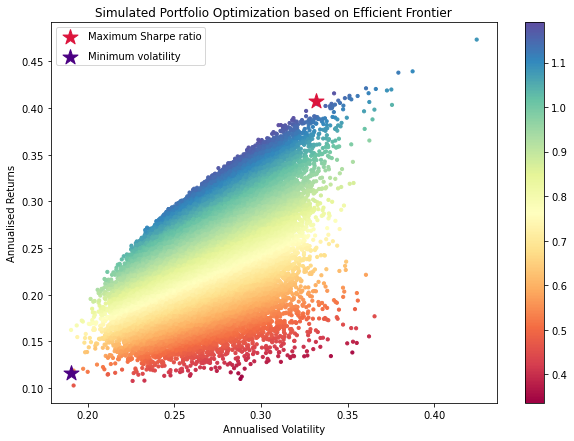

In [123]:
num_portfolios = 100000
#US treasury bond yield as of 23/07/2021
risk_free_rate = 0.01286

# Simulating Portfolios based on Efficient Frontier
display_simulated_ef_with_random(sdata, num_portfolios, risk_free_rate)

# 3. Using optimization algorithms
- Optimization involves finding and selecting the best allocations for our stock portfolio subject to certain constraints

In [124]:
# 1. define a function that outputs the annualised portfolio performance
def annualised_portfolio_performance2(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))* 252)
    return returns, std

In [125]:
def random_portfolios2(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_std_dev = annualised_portfolio_performance2(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_return
        results[1,i] = portfolio_std_dev
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [126]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_ret, p_std = annualised_portfolio_performance2(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [127]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return annualised_portfolio_performance2(weights, mean_returns, cov_matrix)[1]
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [144]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    def portfolio_return(weights):
        return annualised_portfolio_performance2(weights, mean_returns, cov_matrix)[0]
    
    cons = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bnds, constraints=cons)
    return result
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [145]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios2(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    rp, sdp = annualised_portfolio_performance2(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=sdata.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol = min_variance(mean_returns, cov_matrix)
    rp_min, sdp_min = annualised_portfolio_performance2(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=sdata.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:],results[0,:],c=results[2,:],cmap='Spectral', marker='o', s=10, alpha=1.0)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=250, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='indigo',s=250, label='Minimum volatility')
    target = np.linspace(rp_min, 0.40, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing = 0.8)

In [146]:
mean_returns = annualised_asset_performance(sdata)
cov_matrix = port_cov_matrix(sdata)
num_portfolios = 100000
risk_free_rate = 0.01286

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.4
Annualised Volatility: 0.32


             BA  INTC   KO     MS   NFLX   NVDA
allocation  0.0   0.0  0.0  25.99  31.62  42.39
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.19


             BA  INTC     KO    MS   NFLX  NVDA
allocation  0.0  3.63  78.86  2.65  14.86   0.0


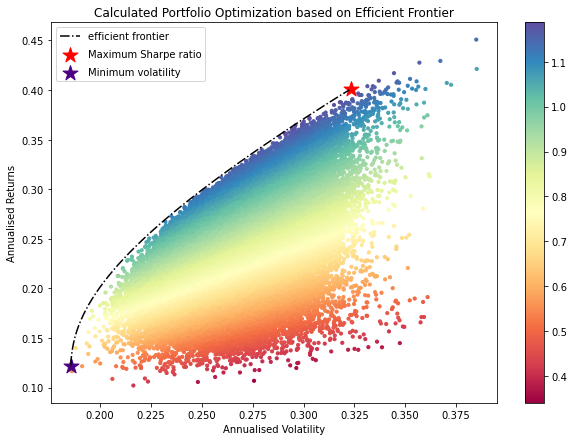

In [147]:
# Calculating Portfolios based on Efficient Frontier
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# 4. Portfolio allocations based on investor utility

In [148]:
def utility_optimal_portfolio(data,risk_aversion_coeff):
    
    # Expected Returns
    mu = expected_returns.mean_historical_return(data)
    # Expected Volatility
    Sigma = risk_models.sample_cov(data)
    ef = EfficientFrontier(mu, Sigma)  # setup
    ef.add_objective(objective_functions.L2_reg)  # add a secondary objective
    weights = ef.max_quadratic_utility(risk_aversion=risk_aversion_coeff, market_neutral=False)  # find the portfolio that maximizes utility
    ret,vol,sharpe_r = ef.portfolio_performance(risk_free_rate=0.01286)
    # loop to iterate for values  
    res = dict() 
    for key in weights:  
    # rounding to K using round() 
        res[key] = round(weights[key], 2) 
    
    return "Allocation: " + str(res), "Annualised Return: " + str(round(ret,2)), "Annualised Volatility: " + str(round(vol,2)), "Sharpe Ratio: " + str(round(sharpe_r,2))

In [149]:
# risk-loving (aggressive) investor
utility_optimal_portfolio(sdata,1)

("Allocation: {'BA': 0.08, 'INTC': 0.09, 'KO': 0.08, 'MS': 0.17, 'NFLX': 0.23, 'NVDA': 0.35}",
 'Annualised Return: 0.43',
 'Annualised Volatility: 0.3',
 'Sharpe Ratio: 1.39')

In [150]:
#moderate risk-taking investor
utility_optimal_portfolio(sdata,4)

("Allocation: {'BA': 0.08, 'INTC': 0.09, 'KO': 0.14, 'MS': 0.18, 'NFLX': 0.22, 'NVDA': 0.28}",
 'Annualised Return: 0.39',
 'Annualised Volatility: 0.28',
 'Sharpe Ratio: 1.35')

In [151]:
#risk averse investor
utility_optimal_portfolio(sdata,9)

("Allocation: {'BA': 0.06, 'INTC': 0.09, 'KO': 0.22, 'MS': 0.19, 'NFLX': 0.22, 'NVDA': 0.22}",
 'Annualised Return: 0.34',
 'Annualised Volatility: 0.25',
 'Sharpe Ratio: 1.29')